In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def K(x, sigma=1, dim=7):
    w = np.linalg.norm(x, ord=2)
    return np.exp(-w ** 2 / 2 / sigma**2) / (2 * np.pi * sigma**2)**(dim/2)

In [3]:
df = pd.read_csv('kc_house_data_NaN.csv').iloc[:, 1:]

# Feature Processing

In [4]:
area_feature = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
year_feature = ['yr_built', 'yr_renovated']
other_feature = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

In [5]:
df['yr_renovated'] = df.apply(lambda x: x['yr_built'] if x['yr_renovated'] == 0 else x['yr_renovated'], axis=1)
df.drop(15870) # an outlier
df = df.dropna().reset_index(drop=True)
df.iloc[:, 2:] = df.iloc[:, 2:].astype('float')

In [6]:
# split dataset
np.random.seed(42)
shuffle_index = np.random.permutation(len(df))
train_dataset = df.loc[shuffle_index[:10000]]
unlabeled_dataset = df.loc[shuffle_index[10000:20000]]
labeled_dataset = df.loc[shuffle_index[20000:21500]]
test_dataset = df.loc[shuffle_index[21500:]]

In [7]:
# train model
import xgboost
model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(train_dataset[area_feature+year_feature+other_feature], train_dataset['price'])
labeled_dataset['pred'] = model.predict(labeled_dataset[area_feature+year_feature+other_feature]).astype('float')
unlabeled_dataset['pred'] = model.predict(unlabeled_dataset[area_feature+year_feature+other_feature]).astype('float')

In [8]:
# decompose features
from sklearn.decomposition import PCA
pca_area = PCA(n_components=2)
pca_area.fit(train_dataset[area_feature])
pca_area_std = np.sqrt(pca_area.explained_variance_)
train_dataset['pca_area_1'] = pca_area.transform(train_dataset[area_feature])[:, 0] / pca_area_std[0]
train_dataset['pca_area_2'] = pca_area.transform(train_dataset[area_feature])[:, 1] / pca_area_std[1]
test_dataset['pca_area_1'] = pca_area.transform(test_dataset[area_feature])[:, 0] / pca_area_std[0]
test_dataset['pca_area_2'] = pca_area.transform(test_dataset[area_feature])[:, 1] / pca_area_std[1]
labeled_dataset['pca_area_1'] = pca_area.transform(labeled_dataset[area_feature])[:, 0] / pca_area_std[0]
labeled_dataset['pca_area_2'] = pca_area.transform(labeled_dataset[area_feature])[:, 1] / pca_area_std[1]
unlabeled_dataset['pca_area_1'] = pca_area.transform(unlabeled_dataset[area_feature])[:, 0] / pca_area_std[0]
unlabeled_dataset['pca_area_2'] = pca_area.transform(unlabeled_dataset[area_feature])[:, 1] / pca_area_std[1]

pca_year = PCA(n_components=1)
pca_year.fit(train_dataset[year_feature])
pca_year_std = np.sqrt(pca_year.explained_variance_)
train_dataset['pca_year'] = pca_year.transform(train_dataset[year_feature]) / pca_year_std
test_dataset['pca_year'] = pca_year.transform(test_dataset[year_feature]) / pca_year_std
labeled_dataset['pca_year'] = pca_year.transform(labeled_dataset[year_feature]) / pca_year_std
unlabeled_dataset['pca_year'] = pca_year.transform(unlabeled_dataset[year_feature]) / pca_year_std

pca_other = PCA(n_components=2)
pca_other.fit(train_dataset[other_feature[:-2]]) # exclude condition and grade since they are already subjective features
pca_other_std = np.sqrt(pca_other.explained_variance_)
train_dataset['pca_other_1'] = pca_other.transform(train_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
train_dataset['pca_other_2'] = pca_other.transform(train_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]
test_dataset['pca_other_1'] = pca_other.transform(test_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
test_dataset['pca_other_2'] = pca_other.transform(test_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]
labeled_dataset['pca_other_1'] = pca_other.transform(labeled_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
labeled_dataset['pca_other_2'] = pca_other.transform(labeled_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]
unlabeled_dataset['pca_other_1'] = pca_other.transform(unlabeled_dataset[other_feature[:-2]])[:, 0] / pca_other_std[0]
unlabeled_dataset['pca_other_2'] = pca_other.transform(unlabeled_dataset[other_feature[:-2]])[:, 1] / pca_other_std[1]

condition_mean, condition_std = train_dataset['condition'].mean(), train_dataset['condition'].std()
train_dataset['condition'] = (train_dataset['condition'] - condition_mean) / condition_std
test_dataset['condition'] = (test_dataset['condition'] - condition_mean) / condition_std
labeled_dataset['condition'] = (labeled_dataset['condition'] - condition_mean) / condition_std
unlabeled_dataset['condition'] = (unlabeled_dataset['condition'] - condition_mean) / condition_std

grade_mean, grade_std = train_dataset['grade'].mean(), train_dataset['grade'].std()
train_dataset['grade'] = (train_dataset['grade'] - grade_mean) / grade_std
test_dataset['grade'] = (test_dataset['grade'] - grade_mean) / grade_std
labeled_dataset['grade'] = (labeled_dataset['grade'] - grade_mean) / grade_std
unlabeled_dataset['grade'] = (unlabeled_dataset['grade'] - grade_mean) / grade_std




In [9]:
def local_inference(target, labeled_set, unlabeled_set, h):
    feature_names = ['pca_area_1', 'pca_area_2', 'pca_year', 'pca_other_1', 'pca_other_2', 'condition', 'grade']
    target_X = target[feature_names].astype('float')

    X = np.concatenate([
        np.ones((1, len(labeled_set))),
        labeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    Y = labeled_set['price'].values.reshape(-1, 1)
    Y_F = labeled_set['pred'].values.reshape(-1, 1)
    W = np.array([K(x[1:]/h) for x in X.T])

    tilde_X = np.concatenate([
        np.ones((1, len(unlabeled_set))),
        unlabeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    tilde_Y_F = unlabeled_set['pred'].values.reshape(-1, 1)
    tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])
    
    beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
    inference = beta[0]

    beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
               np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y)
    inference_ppi = beta_ppi[0]
    
    return (inference[0], inference_ppi[0], target['price'])

In [10]:
from tqdm import tqdm
def get_local_error(label_size, unlabel_size):
    error_df = pd.DataFrame(0, index=test_dataset.index, columns=['abs_error_ppi', 'abs_error', 'mean_error_ppi', 'mean_error', 'error_std_ppi', 'error_std'])
    for i, target in tqdm(test_dataset.iterrows()):
        record_df = pd.DataFrame(0, index=range(100), columns=['infer', 'infer_ppi', 'price'])
        for j in range(100):
            label_sample = labeled_dataset.sample(label_size, random_state=i+j)
            unlabel_sample = unlabeled_dataset.sample(unlabel_size, random_state=i+j)
            infer, infer_ppi, price = local_inference(target, label_sample, unlabel_sample, 1)
            record_df.loc[j] = [infer, infer_ppi, price]
        record_df[['error', 'error_ppi']] = record_df[['infer', 'infer_ppi']].sub(record_df['price'], axis=0)
        error_df.loc[i] = [record_df['error_ppi'].abs().mean(), record_df['error'].abs().mean(), record_df['error_ppi'].mean(), record_df['error'].mean(), record_df['error_ppi'].std(), record_df['error'].std()]
    return error_df

In [11]:
error_df_dict = {}
for label_size, unlabel_size in [(100, 1000), (200, 2000), (400, 4000), (800, 8000), (100, 2000), (100, 4000), (100, 8000)]:
    error_df = get_local_error(label_size, unlabel_size)
    error_df_dict[(label_size, unlabel_size)] = error_df
    break

97it [03:10,  1.96s/it]


In [12]:
error_df_dict[(100, 1000)]

,abs_error_ppi,abs_error,mean_error_ppi,mean_error,error_std_ppi,error_std
3561,50927.308056,46151.718916,-48924.584258,-42754.478124,29365.992951,31359.510832
5892,134853.139405,143661.317754,134853.139405,143661.317754,32946.398984,38623.915542
12666,172345.335604,162873.298309,172345.335604,162873.298309,65143.894872,71360.679521
13986,89760.888629,90535.712188,-88145.585049,-88587.465059,41819.832673,43715.864172
391,217621.645761,242037.948152,217240.351241,242037.948152,81476.487833,94834.194143
...,...,...,...,...,...,...
11964,95891.917832,97469.444986,-95505.970342,-96974.080953,28476.344749,32063.582474
21575,67437.254459,70759.983019,-64650.653294,-67375.837887,44607.330344,49002.328708
5390,69536.437691,74130.731291,-60520.217646,-69514.079395,59151.861951,62803.228142
860,136778.486147,165540.435858,-52803.753954,-88211.138089,182561.402346,205001.038063


In [13]:
record_df = error_df_dict[(100, 1000)].copy()

record_df['ppi_ratio']  = (record_df['error_std'] - record_df['error_std_ppi']) / (record_df['error_std']) 
record_df['abs_error_ratio'] = (record_df['abs_error'] - record_df['abs_error_ppi'])  / (record_df['abs_error'])
record_df['mse_ratio'] = (record_df['mean_error'] - record_df['mean_error_ppi']) / (record_df['mean_error']) 
print(record_df['ppi_ratio'].mean(), record_df['abs_error_ratio'].mean(), record_df['mse_ratio'].mean())


0.14235681581229775 0.05744755254080925 -0.07444080833045987


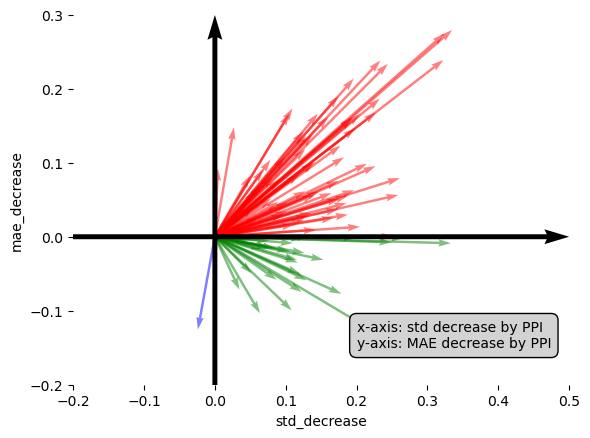

In [14]:
fig, ax = plt.subplots()
alpha = 0.5
for i in range(97):
    x, y = record_df.iloc[i][['ppi_ratio', 'abs_error_ratio']]
    if x > 0 and y > 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='r', alpha=alpha, width=0.005)
    if x < 0 and y < 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='b', alpha=alpha, width=0.005)
    if x > 0 and y < 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='g', alpha=alpha, width=0.005)
    if x < 0 and y > 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='y', alpha=alpha, width=0.005)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.quiver(-0.8, 0, 1.3, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.01)
ax.quiver(0, -0.5, 0, 0.8, angles='xy', scale_units='xy', scale=1, color='k', width=0.01)

plt.annotate('x-axis: std decrease by PPI\ny-axis: MAE decrease by PPI', xy=(0.2, -0.15),bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="lightgray"))
plt.xlim(-0.2, 0.5)
plt.ylim(-0.2, 0.3)
plt.xlabel('std_decrease')
plt.ylabel('mae_decrease')

plt.savefig('house price plot.png')

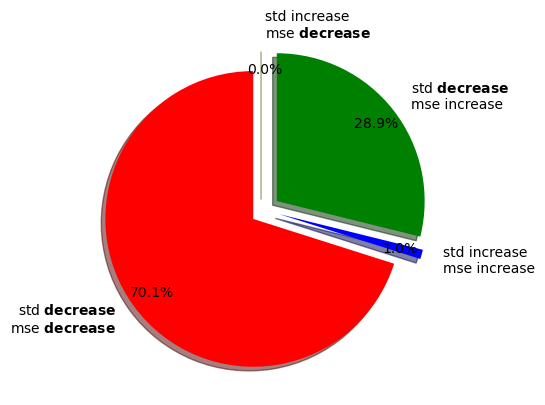

In [15]:
red, blue, green, yellow = 0, 0, 0, 0
for i in range(97):
    x, y = record_df.iloc[i][['ppi_ratio', 'abs_error_ratio']]
    if x > 0 and y > 0:
        red += 1
    if x < 0 and y < 0:
        blue += 1
    if x > 0 and y < 0:
        green += 1
    if x < 0 and y > 0:
        yellow += 1

labels = [
    'std $\mathbf{decrease}$\nmse $\mathbf{decrease}$',
    'std increase\nmse increase',
    'std $\mathbf{decrease}$\nmse increase',
    'std increase\nmse $\mathbf{decrease}$'
]


plt.pie([red, blue, green, yellow], colors=['red', 'blue','green',  'yellow'], explode=(0.1, 0.1, 0.1, 0.1), autopct='%1.1f%%', shadow=True, startangle=90, labels=labels, labeldistance=1.15, pctdistance=0.85)

# plt.show()
plt.savefig('house_price_pie.png')


In [16]:
ers = error_df['mean_error']
ers_ppi = error_df['mean_error_ppi']
stds = error_df['error_std']
stds_ppi = error_df['error_std_ppi']

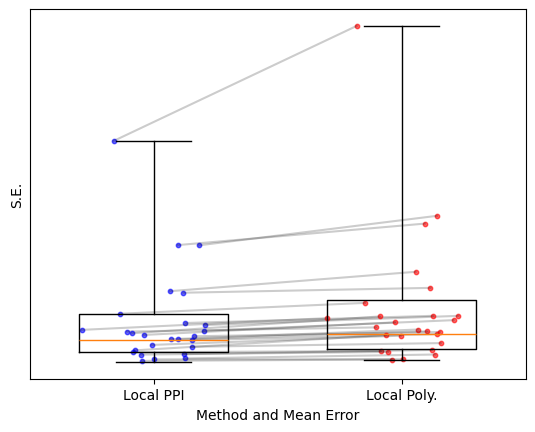

In [17]:
positions = [1, 2]

error_df_filtered = error_df[((error_df[['mean_error_ppi', 'mean_error','error_std_ppi', 'error_std']] < error_df[['mean_error_ppi', 'mean_error','error_std_ppi', 'error_std']].quantile(0.975, axis=0)) & (error_df > error_df[['mean_error_ppi', 'mean_error','error_std_ppi', 'error_std']].quantile(0.025, axis=0))).all(axis=1)][['mean_error_ppi', 'mean_error','error_std_ppi', 'error_std']]
er, er_ppi = error_df_filtered['mean_error'], error_df_filtered['mean_error_ppi']
std, std_ppi = error_df_filtered['error_std'], error_df_filtered['error_std_ppi']

boxplot_dict = plt.boxplot([std_ppi, std], positions=positions, widths=0.6, showfliers=False, zorder=10, whis=[5, 95])

# Set custom labels
plt.xticks([1, 2], ['Local PPI', 'Local Poly.'])


upper_std = std.quantile(0.95)
lower_std = std.quantile(0.05)

upper_std_ppi = std_ppi.quantile(0.95)
lower_std_ppi = std_ppi.quantile(0.05)


x_scatter_1 = er / max(er_ppi.max(), er.max()) / 4 + 2
y_scatter_1 = std 

# plt.scatter(x_scatter_1, y_scatter_1, color='blue', zorder=5, label="Scatter Points", alpha=0.6)

x_scatter_2 = er_ppi / max(er_ppi.max(), er.max()) / 4 + 1
y_scatter_2 = std_ppi

# plt.scatter(x_scatter_2, y_scatter_2, color='red', zorder=5, label="Scatter Points", alpha=0.6)


# # Plot the scatter points (near x=1 and x=2)
# plt.scatter(x_scatter, y_scatter, color='red', zorder=5, label="Scatter Points")
whiskers = [item.get_ydata()[1] for item in boxplot_dict['whiskers']]
max_values = [whiskers[i*2+1] for i in range(2)]
min_values = [whiskers[i*2] for i in range(2)]


# Add title and labels


for i in range(len(er[:30])):
    if y_scatter_1.iloc[i] < min_values[1] or y_scatter_1.iloc[i] > max_values[1] or y_scatter_2.iloc[i] < min_values[0] or y_scatter_2.iloc[i] > max_values[0]:
        continue
    plt.scatter([x_scatter_1.iloc[i]], [y_scatter_1.iloc[i]], color='red', zorder=1, alpha=0.6, s=10)
    plt.scatter([x_scatter_2.iloc[i]], [y_scatter_2.iloc[i]], color='blue', zorder=1, alpha=0.6, s=10)
    plt.plot([x_scatter_1.iloc[i], x_scatter_2.iloc[i]], [y_scatter_1.iloc[i], y_scatter_2.iloc[i]], color='black', zorder=1, alpha=0.2)


# plt.title('Comparison of Local PPI and Local Polynomial')
plt.xlabel('Method and Mean Error')
plt.ylabel('S.E.')
plt.yticks([])

# plt.show()
plt.savefig('house_price_box.png')

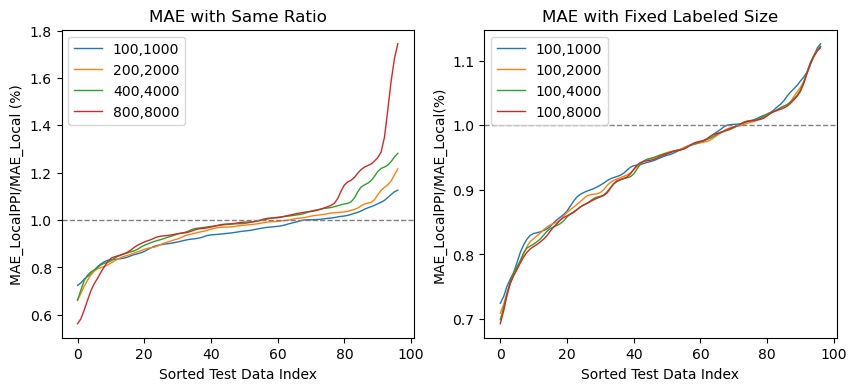

In [18]:
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
for key in [(100, 1000), (200, 2000), (400, 4000), (800, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['abs_error_ppi']/error_df_dict[key]['abs_error'])), sigma=1)
    ax1.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax1.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax1.legend()
ax1.set_title('MAE with Same Ratio')
ax1.set_xlabel('Sorted Test Data Index')
ax1.set_ylabel('MAE_LocalPPI/MAE_Local (%)')

for key in [(100, 1000), (100, 2000), (100, 4000), (100, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['abs_error_ppi']/error_df_dict[key]['abs_error'])), sigma=1)
    ax2.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax2.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax2.legend()
ax2.set_title('MAE with Fixed Labeled Size')
ax2.set_xlabel('Sorted Test Data Index')
ax2.set_ylabel('MAE_LocalPPI/MAE_Local(%)')


plt.savefig('MAE_plot.png')

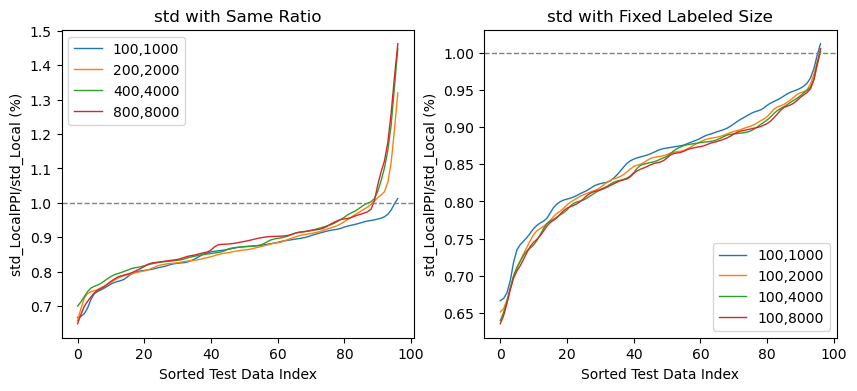

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
for key in [(100, 1000), (200, 2000), (400, 4000), (800, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['error_std_ppi']/error_df_dict[key]['error_std'])), sigma=1)
    ax1.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax1.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax1.legend()
ax1.set_title('std with Same Ratio')
ax1.set_xlabel('Sorted Test Data Index')
ax1.set_ylabel('std_LocalPPI/std_Local (%)')

for key in [(100, 1000), (100, 2000), (100, 4000), (100, 8000)]:
    y = gaussian_filter1d(sorted((error_df_dict[key]['error_std_ppi']/error_df_dict[key]['error_std'])), sigma=1)
    ax2.plot(y, label=str(key[0])+','+str(key[1]), linewidth=1)
ax2.axline((0,1),(1,1), color='gray', linestyle='--', linewidth=1)
ax2.legend()
ax2.set_title('std with Fixed Labeled Size')
ax2.set_xlabel('Sorted Test Data Index')
ax2.set_ylabel('std_LocalPPI/std_Local (%)')


plt.savefig('std_plot.png')